# Aula 4: Soft Actor-Critic (SAC)

---
## Introdução
Neste quarto notebook vamos aprender como implementar o algoritmo Soft Actor-Critic (SAC). Aproveitaremos essa experiência para também aprender sobre Iteração de Política Generalizada, Maximização de Entropia e algoritmos _Actor-Critic_ na prática.

<center>
<img src="img/SAC-GPI.png" width=1000>
</center>

<!-- 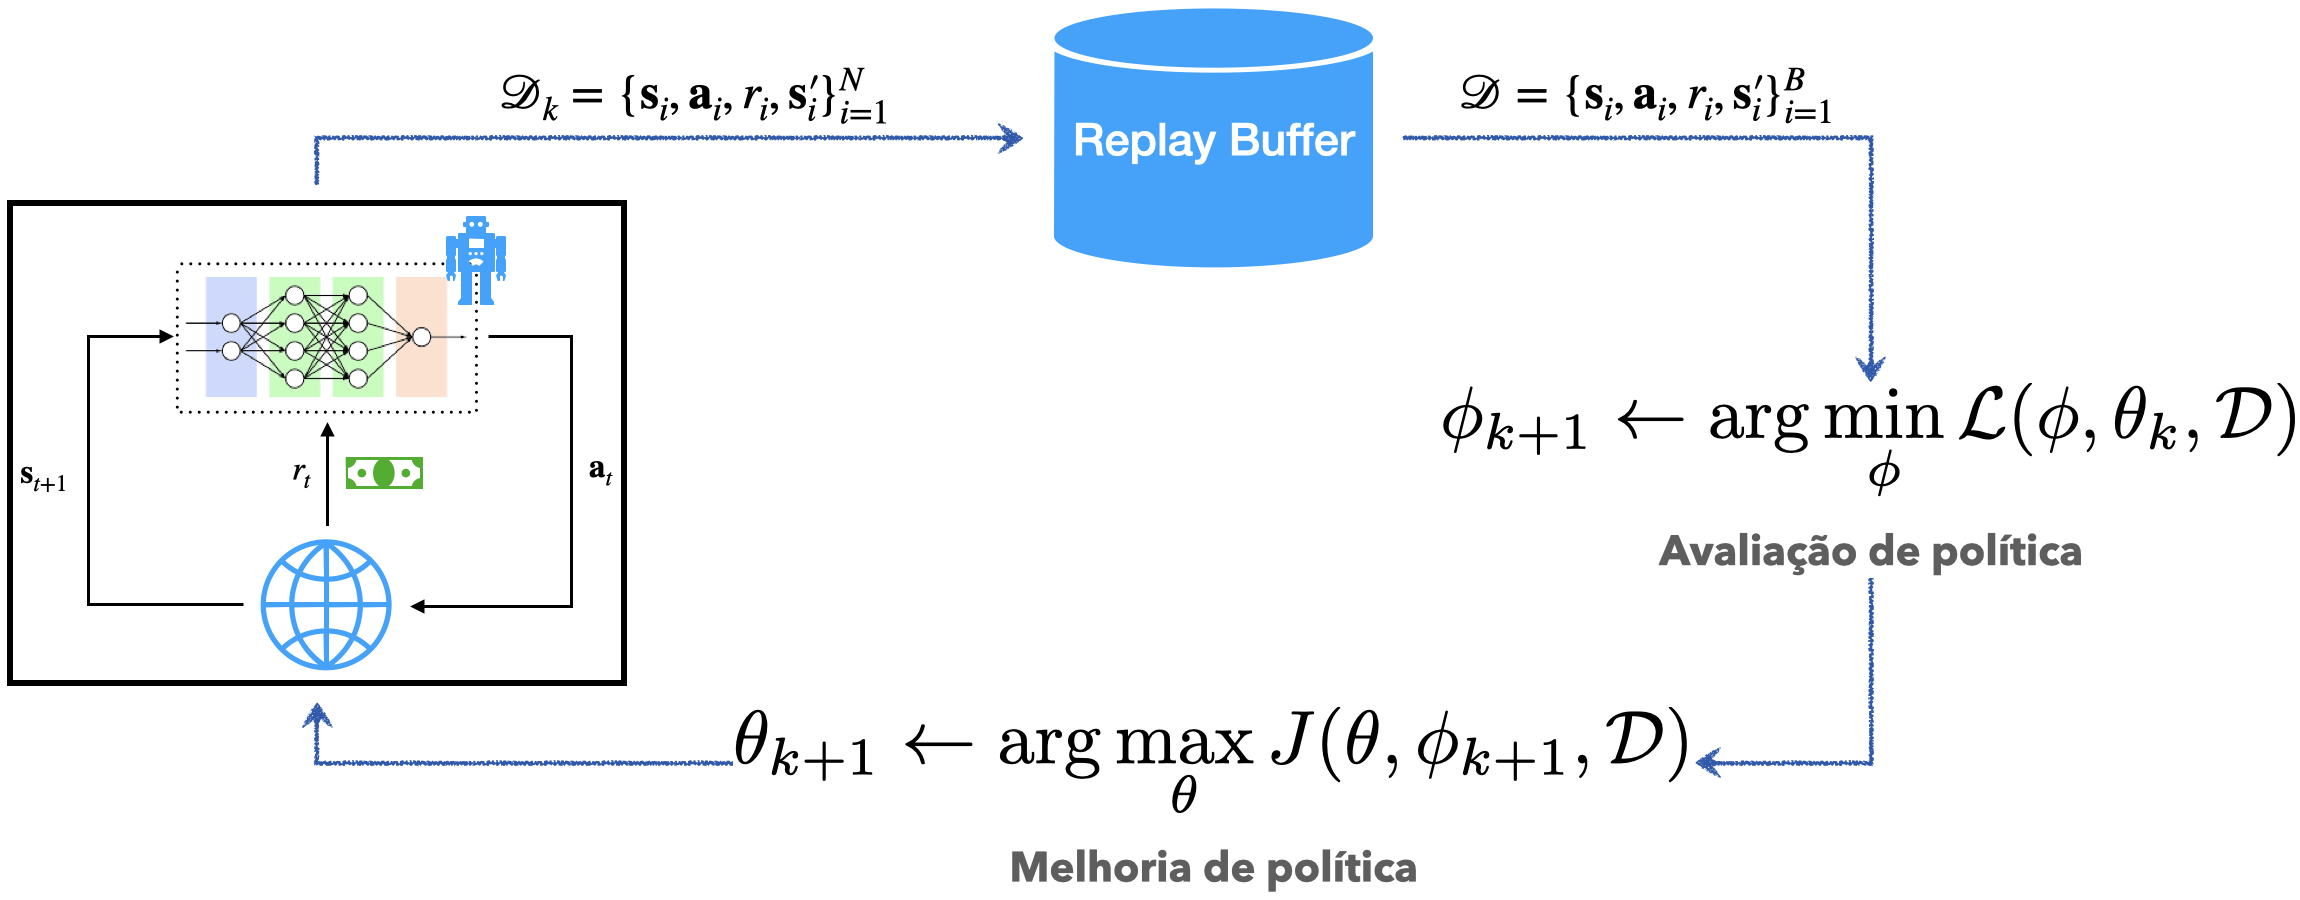 -->

## Objetivos
* Ter um contato com controle contínuo em RL
* Implementar uma política como módulo separado da função-valor
* Entender como Iteração de Política Generalizada é aplicada na prática
* Resolver um problema mais complexo utilizando o simulador de física open-source PyBullet

### Instalação
É necessário rodar a célula abaixo apenas uma vez para instalar as dependências do notebook. **Atenção**: reinicie o kernel depois de rodar a célula abaixo clicando em 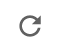 acima

In [ ]:
# atualizar o pip
!pip install -U pip setuptools
# instalar o OpenAI gym do branch master ===> IMPORTANTE!
!pip install -e git+https://github.com/openai/gym.git@master#egg=gym
!pip install tensorflow tensorflow-probability dm-sonnet ipywidgets tqdm gym-cartpole-swingup pybullet
# forcar a versão do pyglet abaixo ===> IMPORTANTE: rodar por último
!pip install pyglet==1.5.11

### Imports

In [ ]:
import os.path as osp
from collections import deque
from dataclasses import dataclass
from datetime import datetime
from typing import Callable
from typing import Dict
from typing import Iterable
from typing import List
from typing import Optional
from typing import Tuple

import gym
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp
from gym.spaces import Box
from gym.wrappers import Monitor
from tqdm.notebook import tqdm, trange

from utils.gym_util import assert_continuous
from utils.gym_util import suppress_box_precision_warning
from utils.logging.tf_logger import TFLogger
from utils.replay.replay import ReplayBuffer
from utils.tf_utils import create_variables
from utils.tf_utils import set_tf_allow_growth
from utils.tf_utils import suppress_tfp_warning


set_tf_allow_growth()
suppress_tfp_warning()
TensorDict = Dict[str, tf.Tensor]
tfd = tfp.distributions
tfb = tfp.bijectors

---
## Implementando políticas explícitas (_Actor_)

<center>
<img src="img/SAC-Actor.png" width=600>
</center>

<!-- 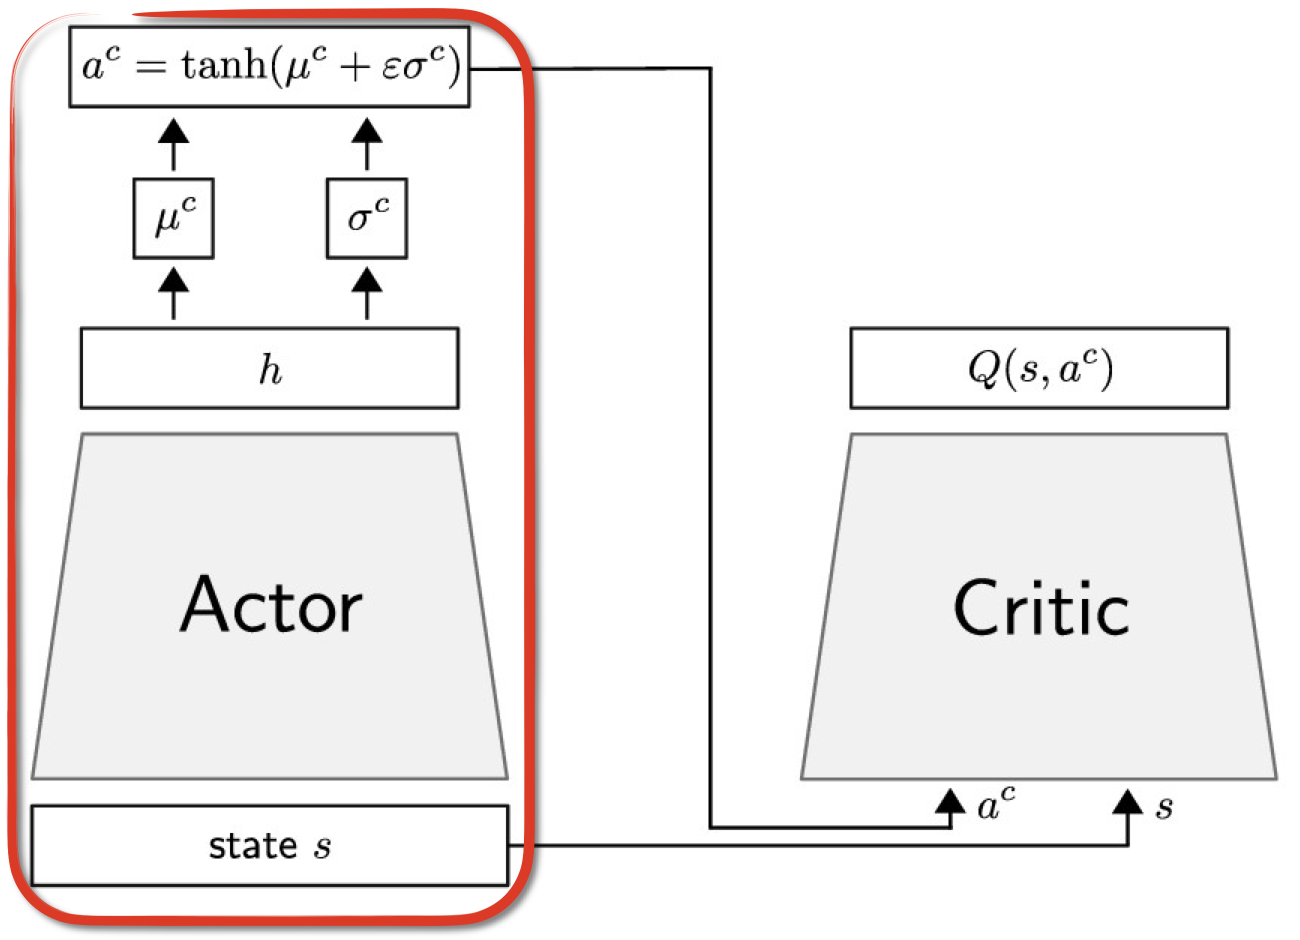 -->

Na aula vimos sobre as vantagens de aprender uma política parametrizada. 

Entre elas está a possibilidade de definir políticas para espaços de ações contínuos. 

Agora veremos como implementar uma política que mapeia as _features_ do estado para uma distribuição Gaussiana.

A classe `StochasticPolicyNetwork` abaixo define a política como um `snt.Module`, assim como a função-valor em aulas passadas.

Detalharemos, em seguida, como usamos o `tensorflow_probability` para definir a computação da distribuição Gaussiana com base nos parâmetros e estado de entrada.

In [ ]:
class StochasticPolicyNetwork(snt.Module):
    """Política estocástica para espaços de ações contínuos.
    
    Mapeia features do estado para parâmetros de uma distribuição Gaussiana
    
    Args:
        observation_space: espaço de observações do ambiente
        action_space: espaço de ações do ambiente
        layers: sequência de tamanhos das camadas escondidas da rede
        name: nome do módulo
    """

    def __init__(self, observation_space: Box, action_space: Box, layers: List[int], name: str = "PolicyNetwork"):
        super().__init__(name=name)
        assert_continuous(observation_space, self, "observação")
        assert_continuous(action_space, self, "ação")
        self.observation_space = observation_space
        self.action_space = action_space
        
        self._encoding_network = snt.nets.MLP(
            layers,
            w_init=snt.initializers.VarianceScaling(1 / 3, "fan_in", "uniform"),
            activate_final=True,
        )

        self._mean_layer = snt.Linear(
            action_space.shape[0],
            w_init=snt.initializers.VarianceScaling(0.1),
            name="output_mean"
        )

        self._log_std_layer = snt.Linear(
            action_space.shape[0],
            w_init=snt.initializers.VarianceScaling(0.1),
            name="output_log_stddev"
        )

        low, high = action_space.low, action_space.high
        offset, scale = (low + high) / 2, (high - low) / 2
        self._bounded_tanh = tfb.Chain([tfb.Shift(offset), tfb.ScaleMatvecDiag(scale), tfb.Tanh()])

    @tf.function
    def __call__(self, obs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """Computa média e desvio padrão da distribuição base sobre ações."""
        h = self._encoding_network(obs)

        mean = self._mean_layer(h)
        log_stddev = self._log_std_layer(h)

        min_log_stddev, max_log_stddev = -5.0, 2.0
        bounded_log_stddev = max_log_stddev - tf.nn.softplus(max_log_stddev - log_stddev)
        bounded_log_stddev = min_log_stddev + tf.nn.softplus(bounded_log_stddev - min_log_stddev)
        stddev = tf.exp(bounded_log_stddev)

        return mean, stddev

    def action_dist(self, obs: tf.Tensor) -> tfd.Distribution:
        """Computa a distribuição sobre ações para um dado estado.
        
        Consiste em uma Gaussiana transformada para espaço de ações limitado.
        """
        mean, stddev = self(obs)
        return tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=mean, scale_diag=stddev),
            bijector=self._bounded_tanh,
            name="BoundedActionDist"
        )

    @tf.function
    def mean(self, obs: tf.Tensor) -> tf.Tensor:
        """Computa a média da distribuição sobre ações."""
        mean, _ = self(obs)
        return self._bounded_tanh(mean)

    @tf.function
    def sample(self, obs) -> tf.Tensor:
        """Amostra uma ação da política."""
        return self.action_dist(obs).sample()

    @tf.function
    def sample_and_log_prob(self, obs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """Amostra uma ação da política e a devolve junto com sua log-densidade de probabilidade."""
        action_dist = self.action_dist(obs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action, log_prob

    @tf.function
    def log_prob(self, obs: tf.Tensor, action: tf.Tensor) -> tf.Tensor:
        """Calcula a log-densidade de probabilidade de uma ação em um estado sob a política."""
        return self.action_dist(obs).log_prob(action)

### Média e desvio padrão a partir do estado

![SAC-ActorTorso.jpg](img/SAC-ActorTorso.jpg)

O primeiro passo é definir como mapear as _features_ do estado para a média ($\mu$) e desvio padrão ($\sigma$) da Gaussiana sobre ações.

O método `__call__` acima desempenha esse papel fazendo uso de um _MultilayerPerceptron_ (MLP) via [`snt.nets.MLP`](https://sonnet.readthedocs.io/en/latest/api.html#mlp).

> **Truques**: note que uma das saídas iniciais do MLP é `log_stddev`. Fazemos isso porquê a saída do MLP tem valores irrestritos, enquanto que o desvio padrão deve ser positivo. Usamos `tf.exp` para converter o log para um valor positivo. Ademais, definimos `min_log_stddev` e `max_log_stddev`, isto é, asseguramos que o log-desvio padrão é limitado. Dessa forma evitamos erros de precisão numérica mais para frente, por exemplo, no cálculo da log-densidade.
> ```python
>        log_stddev = self._log_std_layer(h)
>
>        min_log_stddev, max_log_stddev = -5.0, 2.0
>        bounded_log_stddev = max_log_stddev - tf.nn.softplus(max_log_stddev - log_stddev)
>        bounded_log_stddev = min_log_stddev + tf.nn.softplus(bounded_log_stddev - min_log_stddev)
>        stddev = tf.exp(bounded_log_stddev)
>```

### Gaussiana reparametrizada a partir da média e desvio padrão

As ações em controle contínuo são vetores de valores reais ($\mathbf{a_t} \in \mathcal{A} \subseteq \mathbb{R}^m$). 
Por isso o método `action_dist` faz uso da classe `tfd.MultivariateNormalDiag`, que implementa uma Gaussiana para vetores de variáveis com desvios padrão independentes.

Instâncias de `tfd.MultivariateNormalDiag` possuem vários métodos úteis. 

Usaremos o método `log_prob` para calcular o log da densidade de probalidade uma ação para um dado estado, $\log\pi_\theta(\mathbf{a}|\mathbf{s})$. Lembre-se que isso
será útil para aproximar a entropia da política em um estado:
$$
    \mathcal{H}(\pi_\theta(\cdot|\mathbf{s})) = \mathbb{E}_{\mathbf{a}\sim\pi_\theta(\cdot|\mathbf{s})} \left[ -\log\pi_\theta(\mathbf{a}|\mathbf{s}) \right] \,.
$$

Usaremos também `sample` para amostrar ações de acordo com a política, $\mathbf{a} \sim \pi_\theta(\cdot|\mathbf{s})$, o que detalharemos em seguida.

#### `sample`

<center>
    <img src="img/SCG.png" width=600>
</center>

Ao longo do treinamento, precisamos amostrar ações para interação com ambiente e cálculo de custo/entropia.

O segundo caso é de interesse especial. Imagine que queremos calcular um custo e derivada sobre amostras de uma distribuição Gaussiana.

$$
    \mathbb{E}_{x\sim\mathcal{N}(\mu,\sigma^2)} \left[ L(x) \right]
$$

Como calculamos a derivada com respeito aos parâmetros da distribuição? `tensorflow_probability` nos permite fazer isso com amostras através do _truque de reparametrização_:

$$
    x = \mu + \sigma\xi, \quad \xi\sim\mathcal{N}(0, 1)
$$

Assim, o cálculo do gradiente pode ser feito via Monte-Carlo, pois

$$
\begin{align}
    &\nabla_{\mu,\sigma} \mathbb{E}_{x\sim\mathcal{N}(\mu,\sigma^2)} \left[ L(x) \right] \\
    &= \nabla_{\mu,\sigma} \mathbb{E}_{\xi\sim\mathcal{N}(0,1)} \left[ L(\mu + \sigma\xi) \right] \\
    &= \mathbb{E}_{\xi\sim\mathcal{N}(0,1)} \left[ \nabla_{\mu,\sigma} L(\mu + \sigma\xi) \right]
\end{align}
$$

Isso será extremamete útil quando precisarmos calcular o gradiente com respeito as parâmetros da política utilizando _minibatches_ no passo de melhoria.

Podemos verificar que as amostras de uma distribuição são reparametrizadas acessando a propriedade `reparameterization_type`

In [ ]:
tfd.MultivariateNormalDiag(loc=[0.0], scale_diag=[1.0]).reparameterization_type

### Implementando a distribuição para espaços de ações limitados

![SAC-ActorSquashing.jpg](img/SAC-ActorSquashing.jpg)

É comum em tarefas de controle contínuo termos algum limite nos valores das ações. 
Por exemplo, muitos ambientes do OpenAI Gym possuem espaços de ações da forma $\mathcal{A} = [-1,1]^m$.

Assim, fazemos uso da função [_tanh_](https://mathworld.wolfram.com/HyperbolicTangent.html) via `tfb.Tanh` para mapear as amostras de `tfd.MultivariateNormalDiag` para o espaço $[-1,1]^m$, como ilustrado na imagem acima.

Por isso, a distribuição final retornada por `action_dist` é uma `tfd.TransformedDistribution` que aplica uma função bijetora às amostras da distribuição base.

```python
        return tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=mean, scale_diag=stddev),
            bijector=self._bounded_tanh,
            name="BoundedActionDist"
```

> **Detalhe de implementação**: além de `tfb.Tanh` usamos `tfb.Shift` e `tfb.ScaleMatvecDiag` para mapear as amostras resultantes para qualquer espaço limitado do tipo $[a, b]^m$.

> **Atenção**: a transformação da distribuição muda o cálculo do `log_prob` de variáveis (não podemos usar o da distribuição base). Felizmente, `tfd.TransformedDistribution` cuida disso para nós. Para mais detalhes sobre como a nova densidade é calculada, leia sobre a técnica de [_change of variables_](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function).

---
## Implementando as funções valores (_Critic_)

<center>
<img src="img/SAC-Critic.png" width=600>
</center>

Tendo implementado a política na seção anterior, resta implementarmos o aproximador da função valor-ação, ou _Critic_.

A classe `QNetwork` abaixo faz exatamente isso. 
`QNetwork` implementa a função $Q_\phi: \mathcal{S}\times\mathcal{A} \mapsto \mathbb{R}$ através de um _MultilayerPerceptron_.

Uma instância `q_net` de `QNetwork` quando chamada (`q_net(s, a)`) mapeia as _features_ do estado (`s`) e a ação (`a`) para um valor estimado (em _batch_).

Em DQN, implementamos algo ligeiramente diferente, $Q_\phi: \mathcal{S} \mapsto \mathbb{R}^{|\mathcal{A}|}$, isto é, mapeávamos um estado para um vetor de valores para cada ação possível.

Como estamos lidando com um espaço de ações contínuo ($\mathcal{A} \subseteq \mathbb{R}^m$), só conseguimos computar o valor para pares estado-ação.

In [ ]:
class QNetwork(snt.Module):
    """Aproximador paramétrico de uma função valor-ação.

    Args:
        observation_space: o espaço de observações do ambiente
        action_space: o espaço de ações do ambiente
        layers: sequência de tamanhos das camadas escondidas da rede
        nome: nome do módulo
    """

    def __init__(self, observation_space: Box, action_space: Box, layers: List[int], name: str = "QNetwork"):
        super().__init__(name=name)
        assert_continuous(observation_space, self, "observação")
        assert_continuous(action_space, self, "ação")

        self._encoding_network = snt.nets.MLP(
            layers,
            w_init=snt.initializers.VarianceScaling(1 / 3, "fan_in", "uniform"),
            activate_final=True,
        )

        # Inicializamos os pesos da ultima camada de forma que as predicoes iniciais
        # sejam proximas de zero
        self._output_layer = snt.Linear(
            1,
            w_init=snt.initializers.RandomUniform(minval=-0.003, maxval=0.003),
            name="output"
        )

    @tf.function
    def __call__(self, obs: tf.Tensor, action: tf.Tensor) -> tf.Tensor:
        """Computa o valor estimado de um par estado-ação."""
        inputs = tf.concat([obs, action], axis=-1, name="inputs")
        h = self._encoding_network(inputs)
        q_values = self._output_layer(h)[:, 0]
        return q_values

### Twin Q-Networks

Como comentado em aula, utilizaremos **dois** aproximadores da função valor-ação para mitigar o _viés de superestimação_.

A classe `TwinQNetwork` abaixo encapsula duas `QNetworks` ($Q_{\phi_1}$ e $Q_{\phi_2}$), também como um `snt.Module`. 
Lembre-se que `snt.Module` é um container de parâmetros definidos dentro dele e quaisquer parâmetros de módulos definidos sob ele também.

Para facilitar a nossa vida mais para frente, o método `clipped` computa o mínimo entre os valores preditors por cada _Critic_, 
$$
\min_{i\in\{1,2\}} Q_{\phi_i}(\mathbf{s, a}) \,.
$$

> **Aprofundamento**: um detalhamento melhor sobre o viés de superestimação em algoritmos _Actor-Critic_ pode ser encontrado no artigo [Adressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477). Esse mesmo artigo sugere o uso de dois aproximadores para a função Q como solução, chamando a técnica de _Clipped Double Q-Learning_.

In [ ]:
class TwinQNetwork(snt.Module):
    """Módulo contendo duas QNetwork's distintas.

    Args:
        observation_space: o espaço de observações do ambiente
        action_space: o espaço de ações do ambiente
        layers: sequência de tamanhos das camadas escondidas da rede
        nome: nome do módulo
    """
    
    def __init__(self, observation_space: Box, action_space: Box, layers: List[int], name="TwinQNetwork"):
        super().__init__(name=name)
        self.observation_space = observation_space
        self.action_space = action_space

        self._q_net1 = QNetwork(observation_space, action_space, layers, name="QNet1")
        self._q_net2 = QNetwork(observation_space, action_space, layers, name="QNet2")

    @tf.function
    def __call__(self, obs: tf.Tensor, action: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """Computa os valores estimados por cada QNetwork."""
        q_value1 = self._q_net1(obs, action)
        q_value2 = self._q_net2(obs, action)
        return q_value1, q_value2

    @tf.function
    def clipped(self, obs: tf.Tensor, action) -> tf.Tensor:
        """Computa o mínimo entre os valores estimados por cada QNetwork."""
        q_value1, q_value2 = self(obs, action)
        return tf.math.minimum(q_value1, q_value2)

---
## Funções custo

Diferente de aulas anteriores, temos mais de uma função custo numa abordagem _Actor-Critic_. Detalharemos cada uma a seguir

### Custo do passo de avaliação de política

<center>
<img src="img/Critic-objective.png" width=800>
</center>

Recorde o objetivo de otimização com respeito aos parâmetros de um dos _Critics_, listado acima.

Lembre-se que estamos avaliando a política atual, logo o alvo via _bootstrapping_ usa amostras da política corrente para estimar o valor do próximo estado e sua entropia.

Ademais, note que o alvo no erro quadrático médio acima é o mesmo para ambos os _Critics_: apesar de termos dois deles, tiramos o valor minímo entre eles, resultando em um único _TD target_ para aprendizado dos _Critics_.

---
**<font color="red">EXERCÍCIO-PROGRAMA 1</font>**: Implemente na função abaixo o cálculo do _TD target_ ilustrado acima e armazene-o na variável `q_target`. Em seguida, calcule as predições para cada um dos aproximadores de $Q^\pi$ e compute o custo (quadrado do _Bellman residual_). Finalize somando os dois erros e retornando um escalar.

In [ ]:
def make_critic_loss(
    q_net: TwinQNetwork, target_q_net: TwinQNetwork, policy: StochasticPolicyNetwork, log_alpha: tf.Tensor, gamma: float = 0.99
) -> Callable[[TensorDict], tf.Tensor]:
    @tf.function
    def _loss(batch: TensorDict) -> tf.Tensor:
        obs = batch["obs"]
        action = batch["action"]
        reward = batch["reward"]
        done = tf.cast(batch["terminal"], tf.float32)
        next_obs = batch["next_obs"]

        # SEU CÓDIGO AQUI ===================================

        alpha = tf.exp(log_alpha)        

        # q_values
        q_value1, q_value2 = q_net(obs, action)

        # q_target
        next_action, log_prob = policy.sample_and_log_prob(next_obs)
        next_q_value = target_q_net.clipped(next_obs, next_action)
        q_target = reward + gamma * (1 - done) * (next_q_value - alpha * log_prob)
        q_target = tf.stop_gradient(q_target)

        loss = tf.reduce_mean((q_value1 - q_target) ** 2) + tf.reduce_mean((q_value2 - q_target) ** 2)

        # ===================================================

        return loss

    return _loss

### Custo do passo de melhoria de política

<center>
<img src="img/Actor-objective.png" width=600>
</center>

Recorde o objetivo de otimização com respeito aos parâmetros da política, listado acima.

Esse é um objetivo de maximização. Como otimizadores de biblitecas de _deep learning_ como o Sonnet geralmente trabalham com minimização de funções, devemos inverter o sinal dessa função.

Vamos precisar dos gradientes dessa esperança com respeito aos parâmetros da política. Felizmente, como citado anteriormente, o TensorFlow Probability implementa o truque da reparametrização, então estamos livres para utilizar o método `sample` da política e implementar a função acima como implementaríamos um custo qualquer.

Como citado em aula, podemos usar um dos _Critics_ na computação do valor-ação acima, ou avaliar os dois e tirar o minímo entre eles.

---
**<font color="red">EXERCÍCIO-PROGRAMA 2</font>**: Implemente o custo do passo de melhoria de política, ou seja, o negativo da função ilustrada acima. Sugerimos usar o método `clipped` de `TwinQNetwork` para utilizar o mínimo entre os _Critics_ como valor da ação. Sinta-se à vontada para utilizar apenas um deles se preferir.

In [ ]:
def make_actor_loss(policy: StochasticPolicyNetwork, q_net: TwinQNetwork, log_alpha: tf.Tensor) -> Callable[[TensorDict], tf.Tensor]:
    @tf.function
    def _loss(batch: TensorDict) -> tf.Tensor:
        obs = batch["obs"]

        # SEU CÓDIGO AQUI ===================================

        alpha = tf.exp(log_alpha)
        action, log_prob = policy.sample_and_log_prob(obs)
        q_value = q_net.clipped(obs, action)
        loss = -tf.reduce_mean(q_value - alpha * log_prob)
        
        # ===================================================
        return loss

    return _loss

### Custo do ajuste do coeficiente de entropia

<center>
    <a href="https://medium.com/hackernoon/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752"><img src="img/IntuitiveRL-Entropy.jpg"></a>
</center>

Ao longo do treinamento, conforme a política evolui, a escala relativa dos retornos muda. Isso pode ser um problema se quisermos manter o incentivo à exploração. 

Por exemplo, se a política começa a receber recompensas maiores, a contribuição dos retornos nas funções custo pode ser muito maior do que o fator de entropia. Isso pode levar à uma política muito determinística e desestabilizar o treinamento da mesma.

Diferente do que vimos em aula, pensaremos em termos de uma entropia mínima para a política, ao invés de selecionar um coeficiente fixo para a entropia.

Trocaremos então o hiperparâmetro coeficiente de entropia ($\alpha$) por um outro, entropia alvo ($\bar{\mathcal{H}}$), que é mais fácil de interpretar e ajustar.

O coeficiente de entropia ainda existirá, mas será ajustado automaticamente otimizando o seguinte custo.

<center>
<img src="img/Dual-objective.png" width=600>
</center>

<!-- $$
    \mathcal{L}_{\mathcal{H}}(\alpha)
    = \mathbb{E}_{\mathbf{a}\sim\pi_\theta(\cdot|\mathbf{s})} \left[ -\alpha\log\pi_\theta(\mathbf{a}|\mathbf{s}) - \alpha \bar{\mathcal{H}} \right]
$$
 -->

> **Curiosidade**: essa abordagem pode ser vista como um problema dual do problema de MaxEnt. Interessados podem ver a derivação dessa formulação na seção 5 do artigo "Soft Actor-Critic Algorithms and Applications", listado nas referências ao final do notebook.

> **Recomendação**: no artigo "Soft Actor-Critic Algorithms and Applications", os autores recomendam configurar a entropia alvo para $\bar{\mathcal{H}} = -dim(\mathcal{A})$, o que você verá implementado mais para frente como `target_entropy = -env.action_space.shape[0]`. Outro valor que encontramos na nossa experiência com bibliotecas de RL é $\bar{\mathcal{H}} = -dim(\mathcal{A}) / 2$.

In [ ]:
def make_entropy_coeff_loss(log_alpha: tf.Tensor, policy: StochasticPolicyNetwork, target_entropy: float) -> Callable[[TensorDict], tf.Tensor]:
    @tf.function
    def _loss(batch: TensorDict) -> tf.Tensor:
        obs = batch["obs"]
        alpha = tf.exp(log_alpha)
        _, log_prob = policy.sample_and_log_prob(obs)
        entropy = -tf.reduce_mean(log_prob)
        entropy_diff = tf.stop_gradient(entropy - target_entropy)
        return alpha * entropy_diff

    return _loss

---
## Função de atualização de parâmetros

<center>
<img src="img/optimization.jpg" width=400>
</center>

Assim como em aulas anteriores, utilizaremos métodos de otimização baseado na técnica de [Gradiente Descendente](https://en.wikipedia.org/wiki/Gradient_descent) Estocástico.

Na prática optamos novamente por usar o otimizador [Adam](https://sonnet.readthedocs.io/en/latest/api.html#adam).

A função `make_update_fn` abaixo recebe a função custo (`loss_fn`), as variáves sobre as quais queremos otimizar (`trainable_variables`) e a taxa de aprendizado para o otimizador (`learning_rate`). 

Ela define uma outra função que calcula o custo usando um _minibatch_ (`loss = loss_fn(batch)`), propaga os gradientes do custo com respeito às variáveis (`grads = tape.gradient(loss, trainable_variables)`) e atualiza as variáveis aplicando os gradientes via o otimizador (`optimizer.apply(grads, trainable_variables`).

Isso é útil pois otimizaremos diferentes funções custo com respeito a diferentes parâmetros, como vimos em seções anteriores. Cada objetivo utilizará uma instância diferente do Adam.

In [ ]:
def make_update_fn(
    loss_fn: Callable[[TensorDict], tf.Tensor], trainable_variables: Iterable[tf.Tensor], learning_rate: float
) -> Callable[[TensorDict], Tuple[tf.Tensor, TensorDict]]:
    optimizer = snt.optimizers.Adam(learning_rate)

    @tf.function
    def _update_fn(batch: TensorDict) -> Tuple[tf.Tensor, TensorDict]:
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(trainable_variables)
            loss = loss_fn(batch)

        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply(grads, trainable_variables)

        grads_and_vars = {var.name: (grad, var) for grad, var in zip(grads, trainable_variables)}

        return loss, grads_and_vars

    return _update_fn

### Atualização das redes alvo (_target networks_)

Após cada passo de gradiente descendente no objetivo dos _Critics_, atualizamos os parâmetros das redes alvo correspondentes.

Isso é diferente do DQN, em que tínhamos um hiperparâmetro para controlar a frequência de atualização das redes alvo.

Entretanto, aqui a atualização é feita de maneira suave, através de _polyak averaging_ (vide a função `soft_update` abaixo):

$$
\bar\phi_i \gets \tau\bar\phi_i + (1 - \tau) \phi_i
$$

Assim, precisamos de um outro hiperparâmetro, $\tau\in[0,1]$, para controlar a velocidade de atualização dos parâmetros das redes alvo em direção aos das redes principais.

> **Detalhe**: a função `hard_update` ainda será usada para sincronizar as redes antes do treinamento.

In [ ]:
@tf.function
def hard_update(source_net: snt.Module, target_net: snt.Module):
    """Copia os parâmetros de um módulo para outro."""
    for source_var, target_var in zip(source_net.trainable_variables, target_net.trainable_variables):
        target_var.assign(source_var)

@tf.function
def soft_update(tau: float, source_net: snt.Module, target_net: snt.Module):
    """Move os parâmetros de um módulo na direção dos de outro via polyak averaging."""
    for source_var, target_var in zip(source_net.trainable_variables, target_net.trainable_variables):
        target_var.assign(tau * target_var + (1 - tau) * source_var)

---
## Agente SAC

A classe `SAC` abaixo implementa um agente de aprendizado por reforço que interage com o ambiente e aprende de acordo com o algoritmo SAC.

In [ ]:
@dataclass
class AgentSpec:
    """Specificações para a criação de um agente SAC.
    
    Args:
        layers: sequência de tamanhos das camadas escondidas de cada rede
        target_entropy: entropia alvo da política
        gamma: fator de desconto para recompensas futuras
        tau: coeficiente para polyak averaging das redes alvo do Critic
        learning_rate: taxa de aprendizado para os otimizadores Adam
        checkpoint_dir: diretório para salvar o estado do agente periodicamente
    """
    layers: List[int]
    target_entropy: float
    gamma: float = 0.99
    tau: float = 0.995
    learning_rate: float = 3e-4
    checkpoint_dir: str = "ckpt"


class SAC:
    """Agente de RL que interage com um ambiente e aprende de acordo com o algoritmo SAC.
    
    Args:
        observation_space: o espaço de observações do ambiente
        action_space: o espaço de ações do ambiente
        spec: especificações para a criação do agente
    """
    def __init__(self, observation_space: Box, action_space: Box, spec: AgentSpec):
        self.observation_space = observation_space
        self.action_space = action_space
        self.spec = spec

        self.policy = StochasticPolicyNetwork(observation_space, action_space, spec.layers)
        self.q_net = TwinQNetwork(observation_space, action_space, spec.layers, name="TwinQNet")
        self.target_q_net = TwinQNetwork(observation_space, action_space, spec.layers, name="TargetTwinQNet")
        self.log_alpha = tf.Variable(0.0, name="log_alpha")

        self._ckpt_dir = spec.checkpoint_dir
        self._ckpt = tf.train.Checkpoint(
            policy=self.policy, 
            q_net=self.q_net, 
            target_q_net=self.target_q_net,
            log_alpha=self.log_alpha
        )
        self._ckpt_manager = tf.train.CheckpointManager(self._ckpt, directory=self._ckpt_dir, max_to_keep=1)

    def build(self):
        """Cria as variáveis dos módulos e sincroniza as redes alvo inicialmente."""
        obs_input_spec = tf.TensorSpec(self.observation_space.shape, dtype=tf.float32)
        action_input_spec = tf.TensorSpec(self.action_space.shape, dtype=tf.float32)
        create_variables(self.policy, obs_input_spec)
        create_variables(self.q_net, obs_input_spec, action_input_spec)
        create_variables(self.target_q_net, obs_input_spec, action_input_spec)

        # Inicializamos as redes alvo para serem identicas as principais
        hard_update(self.q_net, self.target_q_net)

        self.update_actor = make_update_fn(
            make_actor_loss(self.policy, self.q_net, self.log_alpha),
            self.policy.trainable_variables,
            learning_rate=self.spec.learning_rate
        )

        self.update_critic = make_update_fn(
            make_critic_loss(self.q_net, self.target_q_net, self.policy, self.log_alpha, gamma=self.spec.gamma),
            self.q_net.trainable_variables,
            learning_rate=self.spec.learning_rate
        )

        self.update_alpha = make_update_fn(
            make_entropy_coeff_loss(self.log_alpha, self.policy, self.spec.target_entropy),
            [self.log_alpha],
            learning_rate=self.spec.learning_rate
        )

    def step(self, obs: np.ndarray, training: bool = True) -> np.ndarray:
        """Escolhe a ação para a observação dada."""
        obs = tf.convert_to_tensor(obs, dtype=tf.float32)
        action = self.policy.sample(obs) if training else self.policy.mean(obs)
        return action.numpy()

    def learn(self, batch: TensorDict):
        """Recebe um batch de experiências, atualiza os parâmetros das redes, e devolve algumas métricas."""
        critic_loss, critic_grads_and_vars = self.update_critic(batch)
        actor_loss, actor_grads_and_vars = self.update_actor(batch)
        alpha_loss, alpha_grads_and_vars = self.update_alpha(batch)

        # Atualizacaoo das redes alvos por polyak averaging
        soft_update(self.spec.tau, self.q_net, self.target_q_net)

        stats = {
            "critic_loss": critic_loss,
            "actor_loss": actor_loss,
            "alpha_loss": alpha_loss,
            "critic_vars": {key: variable for key, (_, variable) in critic_grads_and_vars.items()},
            "critic_grads": {f"grad_{key}": grad for key, (grad, _) in critic_grads_and_vars.items()},
            "actor_vars": {key: variable for key, (_, variable) in actor_grads_and_vars.items()},
            "actor_grads": {f"grad_{key}": grad for key, (grad, _) in actor_grads_and_vars.items()},
        }
        return stats

    def save(self) -> str:
        """Salva o estado atual do agente (i.e., o valor dos parâmetros das redes) nesse momento."""
        return self._ckpt_manager.save()

    def restore(self, save_path: Optional[str] = None) -> str:
        """Carrega o último checkpoint salvo anteriormente no `save_path`."""
        if not save_path:
            save_path = self._ckpt_manager.latest_checkpoint
        return self._ckpt.restore(save_path)

---
## Protocolo de treinamento, avaliação e teste

Com a classe do `SAC` definida, é hora de treinar o agente e avaliá-lo. Faremos isso seguindo um protocolo de treinamento e avaliação definido pelas funções `train` e  `evaluate` abaixo.

<center>
<img src="img/SAC-GPI.png" width=900>
</center>


In [ ]:
def train(
    agent: SAC,
    env: gym.Env,
    test_env: gym.vector.VectorEnv,
    replay: ReplayBuffer,
    logger: TFLogger,
    total_timesteps: int = 100_000,
    learning_starts: int = 5_000,
    learn_every: int = 1,
    evaluation_freq: int = 1_000
):  
    """Treina o agente pela determinada quantidade de passos de tempo.
    
    Args:
        agent: o agente de RL
        env: o ambiente para interação durante o treinamento
        test_env: o ambiente vetorizado para avaliação periódica da política
        replay: replay buffer de experiências
        logger: objeto para registro de métricas para o TensorBoard
        total_timesteps: número de passos total de interação com o ambiente
        learning_starts: quantidade inicial do número total de passos para
            coleta de experiências sem atualização dos componentes (exploração)
        learn_every: frequência, em número de passos no ambiente, de atualização
            do agente (chamada para o método learn)
        evaluation_freq: frequência, em número de passos no ambiente, de
            avaliação da política aprendida no ambiente vetorizado. Essa mesma
            frequência é utilizada para salvar os parâmetros aprendidos (chamada
            ao método save)
    """
    timesteps, episodes, episode_returns = 0, 0, deque(maxlen=100)

    pbar = tqdm(desc="Training", total=total_timesteps, unit="timesteps")
    while timesteps < total_timesteps:
        obs, episode_return = env.reset(), 0.0

        for episode_length in range(1, env.spec.max_episode_steps + 1):
            # collect
            action = agent.step(obs[None, ...], training=True)[0]
            next_obs, reward, done, info = env.step(action)

            timesteps += 1
            episode_return += reward

            # Adicionando experiencia ao replay buffer
            # Note que desconsideramos 'done' se o mesmo foi devido a limite de tempo
            # O limite de tempo e por questoes praticas, as tarefas nesse notebook podem
            # ser rodadas indefinidamente na teoria. Deixamos o agente estimar o valor 
            # esperado pos-'timeout' via bootstrapping
            terminal = done if episode_length < env.spec.max_episode_steps else False
            replay.add(obs, action, reward, terminal, next_obs)

            # training
            if timesteps >= learning_starts and timesteps % learn_every == 0:
                batch = replay.sample()
                train_stats = agent.learn(batch)

            # avaliacao
            if timesteps >= learning_starts and timesteps % evaluation_freq == 0:
                eval_stats = evaluate(agent, test_env)

                # logging
                train_stats["episode_reward_mean"] = np.mean(episode_returns)
                logger.log(timesteps, train_stats, label="train")
                logger.log(timesteps, eval_stats, label="evaluation")

                # checkpointing
                agent.save()

            if done:
                break

            obs = next_obs

        episodes += 1
        episode_returns.append(episode_return)

        # logging
        stats = {
            "episodes": episodes,
            "episode_length": episode_length,
            "episode_return": episode_return,
        }
        logger.log(timesteps, stats, label="collect")
        logger.flush()
        
        pbar.update(episode_length)
        pbar.set_postfix(episodes=episodes, episode_length=episode_length, episode_reward_mean=np.mean(episode_returns))

    # avaliacao final
    stats = evaluate(agent, test_env)
    logger.log(timesteps, stats, label="evaluation")
    logger.flush()

Para avaliarmos o agente, utilizaremos um ambiente paralelizado (contendo `env.num_envs` rodando de forma assíncrona em paralelo). 

> **Observação**: Note no código abaixo, como esse tipo de ambiente altera ligeiramente o ciclo de interação agente-ambiente que vimos na primeira aula. Para maiores detalhes, consulte a documentação de `gym.vector.make` e o código dos módulos em [https://github.com/openai/gym/tree/master/gym/vector](https://github.com/openai/gym/tree/master/gym/vector).

In [ ]:
def evaluate(agent: SAC, env: gym.vector.VectorEnv) -> dict:
    """Avalia a política do agente no ambiente vetorizado.
    
    Completa um ciclo de interação com cada ambiente, efetivamente avaliando
    a política por `env.num_envs` episódios.

    Args:
        agent: o agente de RL
        env: o ambiente vetorizado
        
    Returns:
        Dicionário de métricas de avaliação
    """
    total_reward = np.zeros((env.num_envs,))
    episode_length = np.zeros((env.num_envs,))

    obs = env.reset()
    dones = np.array([False] * env.num_envs)

    while not np.all(dones):
        action = agent.step(obs, training=False)
        obs, reward, done, _ = env.step(action)
        total_reward += (1 - dones) * reward
        episode_length += (1 - dones)
        dones = np.logical_or(dones, done)

    stats = {
        "episode_reward_mean": np.mean(total_reward),
        "episode_reward_min": np.min(total_reward),
        "episode_reward_max": np.max(total_reward),
    }

    return stats         

Execute a célula abaixo para definir um ciclo de interação agente-ambiente para renderizar episódios do agente após o treinamento e então verificar qualitativamente quão boa foi a política que o agente aprendeu.

In [ ]:
def test(agent, env, episodes=3):
    """Testa e renderiza o agente no ambiente por certo número de episódios."""
    for episode in range(episodes):
        obs = env.reset()
        done = False

        while not done:
            action = agent.step(np.expand_dims(obs, axis=0), training=False)[0]
            obs, reward, done, _ = env.step(action)
            env.render()
    env.close()

## Ambiente

A seguinte função instancia o ambiente para treinamento (`env`), o ambiente vetorizado para avaliação periódica da política ao longo do treinamento (`eval_env`) e o ambiente para teste da política aprendida e gravação de vídeos (`test_env`).

In [ ]:
@suppress_box_precision_warning()
def make_envs(env_id, asynchronous: bool = True):
    """Retorna uma tripla com os ambientes para treinamento, avaliação e teste.
    
    Args:
        env_id: identificador do ambiente no gym
        asynchronous: indicador para a criação dos ambientes em subprocessos
            distintos. Pode causar problemas dependendo da implementação do
            ambiente.
    """
    env = gym.make(env_id)
    eval_env = gym.vector.make(env_id, num_envs=10, asynchronous=False)
    test_env = gym.make(env_id)
    return env, eval_env, test_env

## Inicializando o TensorBoard

Antes de iniciarmos o treinamento, execute a célula abaixo para instanciarmos o `tensorboard`, a ferramenta de *logging* e monitoramento do TensorFlow. Consulte a documentação e os tutoriais disponíveis em [https://www.tensorflow.org/tensorboard](https://www.tensorflow.org/tensorboard) para maiores informações.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

---
## Aprendendo a resolver CartPoleSwingUp

<center>
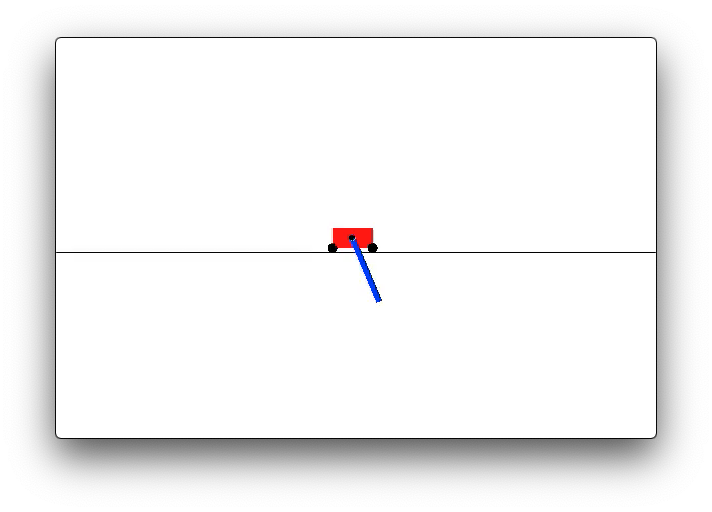
</center>

É boa prática em aprendizado por reforço testar seu agente primeiro em ambientes simples e rápidos de rodar. Isso facilita o entendimento do que pode dar errado e agiliza o processo de _debugging_, evitando longas sessões de treinamento para depois descobrir que havia algo de errado com o código.

Nesse espírito, vamos começar por treinar um agente `SAC` no ambiente `CartPoleSwingUp-v1`, uma tarefa similar ao `CartPole-v1`, com a diferença que o poste começa pendurado para baixo e o agente deve aprender a balançá-lo para cima **e** equilibrá-lo em pé pelo máximo de tempo possível.

O processo de treinamento, se bem sucedido, deve demorar ~12min e obter uma política com recompensa ~400.

> **Atenção**: CartPoleSwingUp causa um 'crash' com `asynchronous=True`. O autor dessa implementação do ambiente é um dos instrutores (Ângelo) e está tentando encontrar a razão desse problema. Caso encontre algum outro problema com o ambiente ou tenha uma sugestão, por favor, abra uma _issue_ no [GitHub do projeto](https://github.com/angelolovatto/gym-cartpole-swingup).

In [ ]:
import gym_cartpole_swingup  # para registrar os ambientes no gym

In [ ]:
env, eval_env, test_env = make_envs("CartPoleSwingUp-v1", asynchronous=False)

timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")
run_id = osp.join(f"sac-{env.spec.id}".lower(), timestamp)

total_timesteps = 200_000
replay = ReplayBuffer(env.observation_space, env.action_space, max_size=total_timesteps, batch_size=128)
replay.build()

spec = AgentSpec(layers=[128, 128], target_entropy=-env.action_space.shape[0], checkpoint_dir=osp.join("ckpt", run_id))
agent = SAC(env.observation_space, env.action_space, spec)
agent.build()

In [ ]:
logger = TFLogger(run_id, base_dir=osp.join("logs", "aula4"))
train(agent, env, eval_env, replay, logger, total_timesteps=total_timesteps)

### Visualizando o agente aprendido

Execute a célula abaixo para carregar a melhor política encontrada durante o treinamento e visualizá-la no ambiente.

In [ ]:
agent = SAC(env.observation_space, env.action_space, spec)
agent.build()
agent.restore()

record(agent, test_env, directory=osp.join("monitor", run_id), episodes=2)

---
## SAC no simulador de física PyBullet

<center>
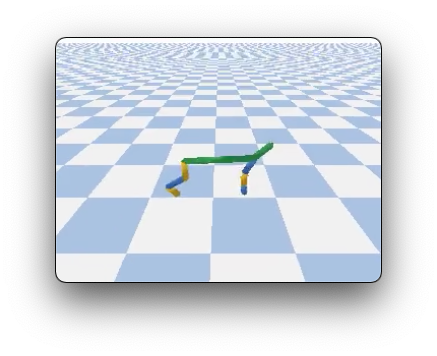
</center>

Agora vamos atacar um simulador um pouco mais desafiador, o [PyBullet](https://pybullet.org/wordpress/). 

PyBullet é uma alternativa livre e _open-source_ ao [MuJoCo](http://www.mujoco.org/), um simulador de física com contatos muito usado em pesquisa para RL e robótica, mas que infelizmente precisa de uma licensa para ser usado.

Os ambientes implementados no PyBullet são registrados no `gym` ao importarmos `pybullet_envs`. Muitos deles imitam os [ambientes de controle contínuo](https://gym.openai.com/envs/#mujoco) implementados via MuJoCo.

Especificamente, vamos testar o agente SAC no ambiente `HalfCheetahBulletEnv-v0`, ilustrado acima, onde o robô imita uma cheetah que se move no plano 2D e o agente deve aprender a controlar o robô via os torques em suas juntas de forma a fazê-lo correr para frente o mais rápido possível.

> **Referência do custo computacional de treinamento**: em um laptop com processador 3.1 GHz Dual-Core Intel Core i5 (sem GPU), consegui treinar o agente por 1M de passos de tempo levando em torno de 6 horas e 45 minutos e atingindo um retorno de avaliação de 2330.

> **Ambientes do PyBullet**: para mais informações sobre os ambientes disponíveis no PyBullet, com uma breve descrição de cada um, acesse o [quickstart guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/).

In [ ]:
import pybullet_envs  # para registrar os ambientes no gym

In [ ]:
env, eval_env, test_env = make_envs("HalfCheetahBulletEnv-v0")

timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")
run_id = osp.join(f"sac-{env.spec.id}".lower(), timestamp)

total_timesteps = 1_000_000
replay = ReplayBuffer(env.observation_space, env.action_space, max_size=total_timesteps, batch_size=256)
replay.build()

spec = AgentSpec(layers=[256, 256], target_entropy=-env.action_space.shape[0], checkpoint_dir=f"ckpt/{run_id}")
agent = SAC(env.observation_space, env.action_space, spec)
agent.build()

In [ ]:
logger = TFLogger(run_id, base_dir=osp.join("logs", "aula4"))
train(agent, env, eval_env, replay, logger, total_timesteps=total_timesteps)

### Gravando um vídeo do agente aprendido

A melhor maneira de visualizar agentes no PyBullet é através do _wrapper_ `Monitor` do `gym`, que grava um vídeo do agente interagindo com o simulador.

In [ ]:
def record(agent: SAC, env: gym.Env, directory: str, episodes: int = 1):
    """Grava um vídeo do agente interagindo com o ambiente.
    
    Args:
        agent: o agente de RL
        env: o ambiente para interação
        directory: diretório no qual Monitor salvará os vídeos
        episodes: número de episódios a serem simulados e gravados
    """
    env = Monitor(env, directory, video_callable=lambda _: True)

    for _ in range(episodes):
        done = False
        obs = env.reset()
        while not done:
            act = agent.step(np.expand_dims(obs, axis=0), training=False)[0]
            new_obs, rew, done, info = env.step(act)
            obs = new_obs
    env.close()

In [ ]:
agent = SAC(env.observation_space, env.action_space, spec)
agent.build()
agent.restore()

directory = osp.join("monitor", run_id)
record(agent, test_env, directory)

---
## Questões e experimentos

**1. Experimente modificar a entropia alvo e executar o treinamento da política**
   1. O que acontece quando usamos uma entropia alvo muito baixa?
   2. O que acontece quando usamos uma entropia alvo muito alta?
   3. Os resultados dos experimentos acima condizem com o que esperaríamos na teoria?
**2. O código foi desenvolvido para ser compatível com vários ambientes de controle contínuo. Experimente rodar o agente SAC em algum outro ambiente do PyBullet, e.g.,** `HopperBulletEnv-v0` **ou** `InvertedPendulumSwingupBulletEnv-v0`.
   1. Visualize o ambiente para ter uma ideia do que esperar do agente na tarefa
   2. Treine o agente com os mesmos hiperparâmetros utilizados na sua última rodada de treinamento bem-sucedida em outro ambiente
   3. O agente resultante tem um bom desempenho no novo ambiente?
   4. Se não, você sabe dizer quais hiperparâmetros influenciaram no resultado negativo (taxa de aprendizado, entropia alvo, arquitetura da rede, etc.)? Experimente mudá-los até conseguir um bom desempenho no novo ambiente.

---
## Conclusões

Ao fazer esse notebook, esperamos que você tenha aprendido:
* Como implementar políticas explícitas em RL utilizando o arcabouço do Sonnet
* Como coordenar os diferentes componentes de um algoritmo _Actor-Critic_ em RL
* Os detalhes de implementação das arquiteturas para controle controle contínuo
* A importância e impacto de exploração em aprendizado por reforço

## Referências
> [Soft actor-critic algorithms and applications](https://arxiv.org/abs/1812.05905), Haarnoja, Tuomas, et al, 2018.
>
> [Discrete and continuous action representation for practical reinforcement learning in Video Games](https://montreal.ubisoft.com/en/discrete-and-continuous-action-representation-for-practical-reinforcement-learning-in-video-games/).
>
> [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477), Fujimoto et al, 2018.
> 
> [PyBullet, a Python module for physics simulation for games, robotics and machine learning](http://pybullet.org), Erwin Coumans and Yunfei Bai, 2019.